<a href="https://colab.research.google.com/github/lpedraoss/AlgorithmsUN2023II/blob/main/Group_8_lab7_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Stable Marriage Problem**


In [ ]:
# Python3 program for the stable marriage problem

# Number of Men or Women
N = 4

# This function returns true if
# woman 'w' prefers man 'm1' over man 'm'
def wPrefersM1OverM(prefer, w, m, m1):

	# Check if w prefers m over her
	# current engagement m1
	for i in range(N):

		# If m1 comes before m in the list of w,
		# then w prefers her current engagement,
		# don't do anything
		if prefer[w][i] == m1:
			return True

		# If m comes before m1 in w's list,
		# then free her current engagement
		# and engage her with m
		if prefer[w][i] == m:
			return False

# Prints stable matching for N boys and N girls.
# Boys are numbered as 0 to N-1.
# Girls are numbered as N to 2N-1.
def stableMarriage(prefer):

	# Stores the partner of women. This is our output
	# array that stores passing information.
	# The value of wPartner[i] indicates the partner
	# assigned to woman N+i. Note that the woman numbers
	# between N and 2*N-1. The value -1 indicates
	# that the (N+i)'th woman is free
	wPartner = [-1 for i in range(N)]

	# An array to store the availability of men.
	# If mFree[i] is false, then man 'i' is free,
	# otherwise, he is engaged.
	mFree = [False for i in range(N)]

	freeCount = N

	# While there are free men
	while freeCount > 0:

		# Pick the first free man (we could pick any)
		m = 0
		while m < N:
			if not mFree[m]:
				break
			m += 1

		# One by one go to all women according to
		# m's preferences. Here m is the picked free man
		i = 0
		while i < N and not mFree[m]:
			w = prefer[m][i]

			# The woman of preference is free,
			# w and m become partners (Note that
			# the partnership may be changed later).
			# So we can say they are engaged not married
			if wPartner[w - N] == -1:
				wPartner[w - N] = m
				mFree[m] = True
				freeCount -= 1

			else:

				# If w is not free
				# Find the current engagement of w
				m1 = wPartner[w - N]

				# If w prefers m over her current engagement m1,
				# then break the engagement between w and m1 and
				# engage m with w.
				if not wPrefersM1OverM(prefer, w, m, m1):
					wPartner[w - N] = m
					mFree[m] = True
					mFree[m1] = False
			i += 1

			# End of Else
		# End of the for loop that goes
		# to all women in m's list
	# End of main while loop

	# Print solution
	print("Woman ", " Man")
	for i in range(N):
		print(i + N, "\t", wPartner[i])

# Driver Code
prefer = ((7, 5, 6, 4), (5, 4, 6, 7),
          (4, 5, 6, 7), (4, 5, 6, 7),
          (0, 3, 4,1), (2, 1, 6, 3),
          (0, 1, 2, 3), (1, 2, 3, 5))

stableMarriage(prefer)



Woman   Man
4 	 3
5 	 2
6 	 1
7 	 0


In [ ]:
# Python3 program for the stable marriage problem
import itertools
# Number of Men or Women
N = 4

def wPrefersM1OverM(prefer, w, m, m1):
    for i in range(N):
        if prefer[w][i] == m1:
            return True
        if prefer[w][i] == m:
            return False

def stableMarriage(prefer):
    wPartner = [-1 for i in range(N)]
    mFree = [False for i in range(N)]
    freeCount = N

    while freeCount > 0:
        m = 0
        while m < N:
            if not mFree[m]:
                break
            m += 1

        i = 0
        while i < N and not mFree[m]:
            w = prefer[m][i]

            if wPartner[w - N] == -1:
                wPartner[w - N] = m
                mFree[m] = True
                freeCount -= 1
            else:
                m1 = wPartner[w - N]
                if not wPrefersM1OverM(prefer, w, m, m1):
                    wPartner[w - N] = m
                    mFree[m] = True
                    mFree[m1] = False
            i += 1

    return wPartner

def checkStability(prefer, pairs):
    wPartner = stableMarriage(prefer)

    print("\nPreferencias:")
    for i in range(N):
        print(f"Preferencias de la mujer {i + N}: {prefer[i + N]}")

    print("\nParejas:")
    for pair in pairs:
        w, m = pair
        current_partner = wPartner[w - N]
        if not wPrefersM1OverM(prefer, w, m, current_partner):
            print(f"{pair} => Inestable")
        else:
            print(f"{pair} => Estable")



n = len(prefer[0])
all_combinations = list(itertools.product(range(n, 2 * n), range(n)))

print("Combinaciones:")
checkStability(prefer, all_combinations)


Combinaciones:

Preferencias:
Preferencias de la mujer 4: (0, 3, 4, 1)
Preferencias de la mujer 5: (2, 1, 6, 3)
Preferencias de la mujer 6: (0, 1, 2, 3)
Preferencias de la mujer 7: (1, 2, 3, 5)

Parejas:
(4, 0) => Inestable
(4, 1) => Estable
(4, 2) => Estable
(4, 3) => Estable
(5, 0) => Estable
(5, 1) => Estable
(5, 2) => Estable
(5, 3) => Estable
(6, 0) => Inestable
(6, 1) => Estable
(6, 2) => Estable
(6, 3) => Estable
(7, 0) => Inestable
(7, 1) => Inestable
(7, 2) => Inestable
(7, 3) => Inestable


The Gale-Shapley algorithm in Python

David Gale and Lloyd Shapley proved that in cases with when two sets are equal there always a way to create stable pairs. I recommend reading the original paper[2] to be familiar with the elegant prove they provided.

There are different implementations of the Gale-Shapley algorithm in Python [3, 4, 5], let’s create this algorithm closer to pseudocode solution without going into complicated OOP.

In a pseudocode solution looks like this [6]:

function stableMatching {
  
    Initialize all m ∈ M and w ∈ W to free
    while ∃ free man m who still has a woman w to propose to {
       w = first woman on m’s list to whom m has not yet proposed
       if w is free
         (m, w) become engaged
       else some pair (m', w) already exists
         if w prefers m to m'
            m' becomes free
           (m, w) become engaged
         else
           (m', w) remain engaged
    }
}

In [ ]:
%pylab inline
import pandas as pd
import numpy as np
from collections import Counter
from copy import copy

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


Define men and women data frames

In [ ]:
man_list = ['a', 'b', 'c', 'd']
women_list = ['A', 'B', 'C', 'D']
women_df = pd.DataFrame({'A': [3,4,2,1], 'B': [3,1,4,2], 'C':[2,3,4,1], 'D':[3,2,1,4]})
women_df.index = man_list
man_df = pd.DataFrame({'A': [1,1,2,4], 'B': [2,4,1,2], 'C':[3,3,3,3], 'D':[4,2,4,1]})
man_df.index = man_list

Gale-Shapley algorithm

In [ ]:
# dict to control which women each man can make proposals
women_available = {man:women_list for man in man_list}
# waiting list of men that were able to create pair on each iteration
waiting_list = []
# dict to store created pairs
proposals = {}
# variable to count number of iterations
count = 0

In [ ]:
# while not all men have pairs
while len(waiting_list)<len(man_list):
    # man makes proposals
    for man in man_list:
        if man not in waiting_list:
            # each man make proposal to the top women from it's list
            women = women_available[man]
            best_choice = man_df.loc[man][man_df.loc[man].index.isin(women)].idxmin()
            proposals[(man, best_choice)]=(man_df.loc[man][best_choice],
                                                 women_df.loc[man][best_choice])
    # if women have more than one proposals
    # she will choose the best option
    overlays = Counter([key[1] for key in proposals.keys()])
    # cycle to choose the best options
    for women in overlays.keys():
        if overlays[women]>1:
            # pairs to drop from proposals
            pairs_to_drop = sorted({pair: proposals[pair] for pair in proposals.keys()
                    if women in pair}.items(),
                   key=lambda x: x[1][1]
                  )[1:]
            # if man was rejected by woman
            # there is no pint for him to make proposal
            # second time to the same woman
            for p_to_drop in pairs_to_drop:
                del proposals[p_to_drop[0]]
                _women = copy(women_available[p_to_drop[0][0]])
                _women.remove(p_to_drop[0][1])
                women_available[p_to_drop[0][0]] = _women
    # man who successfully created pairs must be added to the waiting list
    waiting_list = [man[0] for man in proposals.keys()]
    # update counter
    count+=1


Stable pairs

In [ ]:
proposals

{('b', 'D'): (2, 2),
 ('d', 'B'): (2, 2),
 ('c', 'A'): (2, 2),
 ('a', 'C'): (3, 2)}

In [ ]:
count

6

In [ ]:
!pip install devtools
!pip install animation



In [ ]:
code = """
# deferred acceptance algorithm after Gale and Shapley
# ... (rest of your code)
# deferred acceptance algorithm after Gale and Shapley

# Deferred Acceptance Algorithm with male offer
# accepts your preferences or chooses randomly

daa <- function(nMen,nWomen,m.prefs=NULL,w.prefs=NULL){
	require(animation)	# load animation package

	if (is.null(m.prefs)){	# if no prefs given, make them randomly
		m.prefs <- replicate(n=nMen,sample(seq(from=1,to=nWomen,by=1)))
		w.prefs <- replicate(n=nWomen,sample(seq(from=1,to=nMen,by=1)))
	}
	m.hist    <- rep(0,length=nMen)	# number of proposals made
	w.hist    <- rep(0,length=nWomen)	# current mate
	m.singles <- 1:nMen
	w.singles <- 1:nWomen
	m.mat <- matrix(data=1:nMen,nrow=nMen,ncol=nWomen,byrow=F)
	saveGIF({	# this line and next are for recording the movie
		ani.options(interval=0.5,nmax=nWomen,ani.width=1000,ani.height=1000,dev=png,type="png","convert",outdir=getwd())
		for (iter in 1:nWomen){		# there are as many rounds as maximal preference orders
			# look at market: all single men
			# if history not full (been rejected by all women in his prefs)
			# look at single male's history
			# propose to next woman on list
			offers <- NULL
			for (i in 1:length(m.singles)){
				m.hist[m.singles[i]] <- m.hist[m.singles[i]]+1	# make next proposal according to single i's count
				offers[i] <- m.prefs[m.hist[m.singles[i]],m.singles[i]]		# offer if single i is the index of the woman corresponding to current round
			}
			approached   <- unique(offers)	# index of women who received offers
			temp.singles <- m.singles
			m.singles    <- NULL	# reset singles
			for (j in approached){
				proposers   <- temp.singles[offers==j]
				stay.single <- temp.singles[offers==0]		# guys who prefer staying single at current history
				for (k in 1:length(proposers)){
					if (w.hist[j]==0&any(w.prefs[ ,j]==proposers[k])){	# if no history and proposer
						w.hist[j] <- proposers[k]						# is somewhere on preference list, accept

					} else if (match(w.prefs[w.prefs[ ,j]==proposers[k],j],w.prefs[ ,j])<match(w.prefs[w.prefs[ ,j]==w.hist[j],j],w.prefs[ ,j])){
								m.singles <- c(m.singles,w.hist[j])		# if proposer better, fire current guy
								w.hist[j] <- proposers[k]	# and take proposer on
							} else {
								m.singles <- c(m.singles,proposers[k])	# otherwise k stays single
							}
				}
			}
			m.singles <- sort(c(m.singles,stay.single))
			if (length(m.singles)==0){	# if no singles left: stop
				return(list(m.prefs=m.prefs,w.prefs=w.prefs,iterations=iter,matches=w.hist,singles=m.singles))
				break
			}
		current.match   <- (matrix(rep(w.hist,each=nMen),nrow=nMen,ncol=nWomen)==m.mat)
		current.singles <- matrix(m.mat %in% m.singles,nrow=nMen)*2
		image(y=1:nWomen,x=1:nMen,z=current.match+current.singles,ylab="women",xlab="men",col=c("white","black","red"),
			  sub=paste("Iterations to go: ",nWomen-iter,". currently ",length(m.singles)," males single", sep=""))
		title("Current matches (black) and male singles (red)",line=3)
		title(paste(nMen," men and ",nWomen," women",sep=""),line=2)
		grid(nx=nMen,ny=nWomen,col="black",lty=1)
		}
	},movie.name="dda_plot.gif")	# end movie recorder
	return(list(m.prefs=m.prefs,w.prefs=w.prefs,iterations=iter,matches=w.hist,match.mat=current.match,singles=m.singles))
}
"""

with open("dda2.r", "w") as f:
    f.write(code)


Run the Gale-Shapley Algorithm 100 times using random permutations as preference lists for n=4 and 40. Find the minimum, maximum and average number of iterations and plot the distribution of the number of iterations.

In [ ]:
import random

def generatePreferencesMen(n):
    menPreferences = []

    for i in range(n):
        preferencia = list(range(n))
        random.shuffle(preferencia)
        menPreferences.append(preferencia)

    return menPreferences

In [ ]:
def generatePreferencesWomen(n):
    womenPreferences = []

    for i in range(n):
        preferencia = list(range(n))
        random.shuffle(preferencia)
        womenPreferences.append(preferencia)

    return womenPreferences

In [ ]:
def galeShapley(menPreferences, womenPreferences):
    iterations = []
    n = len(menPreferences)
    comprometidos = [-1] * n  # Inicialmente, nadie está comprometido
    propuestasH = [0] * n  # El numero de propuestas por hombre

    while propuestasH.count(n) != n:  # Mientras haya hombres sin compromiso
        for man in range(n):
            if propuestasH[man] == n:
                continue  # El hombre ya ha propuesto a todas las mujeres
            woman = menPreferences[man][propuestasH[man]]
            propuestasH[man] += 1

            if comprometidos[woman] == -1:  # La mujer está libre
                comprometidos[woman] = man
            else:
                currentMan = comprometidos[woman]
                if womenPreferences[woman].index(man) < womenPreferences[woman].index(currentMan):
                    comprometidos[woman] = man
                    propuestasH[currentMan] = n  # El hombre pierde su compromiso

        iterations.append(propuestasH.count(n))

    return iterations

In [ ]:
galeShapley(generatePreferencesMen(4),generatePreferencesWomen(4))

[1, 3, 3, 4]

In [ ]:
def centimes(n, nTimes):
    minIter = float('inf')
    maxIter = 0
    totalIter = 0
    listIter = []

    for i in range(nTimes):
        menPreferences = [np.random.permutation(n).tolist() for i in range(n)]
        womenPreferences = [np.random.permutation(n).tolist() for i in range(n)]
        iterations = galeShapley(menPreferences, womenPreferences)
        listIter.extend(iterations)

        minIter = min(minIter, min(iterations))
        maxIter = max(maxIter, max(iterations))
        totalIter += sum(iterations)



    aveIter = totalIter / (n * nTimes)

    return listIter, totalIter, minIter, maxIter, aveIter

Para n = 4
Total iterations: 814
Minimum iterations: 0
Maximum iterations: 4
Average iterations: 2.035


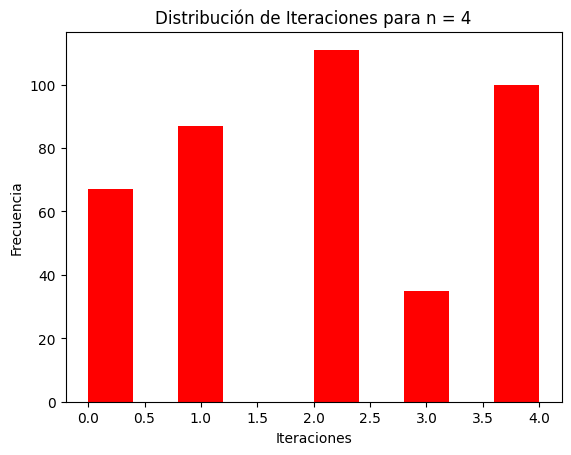

In [ ]:
print("Para n = 4")
listIter, totalIter, minIter, maxIter, aveIter = centimes(4, 100)

print(f"Total iterations: {totalIter}")
print(f"Minimum iterations: {minIter}")
print(f"Maximum iterations: {maxIter}")
print(f"Average iterations: {aveIter}")

import matplotlib.pyplot as plt

plt.hist(listIter, color='red')
plt.title('Distribución de Iteraciones para n = 4')
plt.ylabel('Frecuencia')
plt.xlabel('Iteraciones')

plt.show()

Para n = 40
Total iterations: 137759
Minimum iterations: 3
Maximum iterations: 40
Average iterations: 34.43975


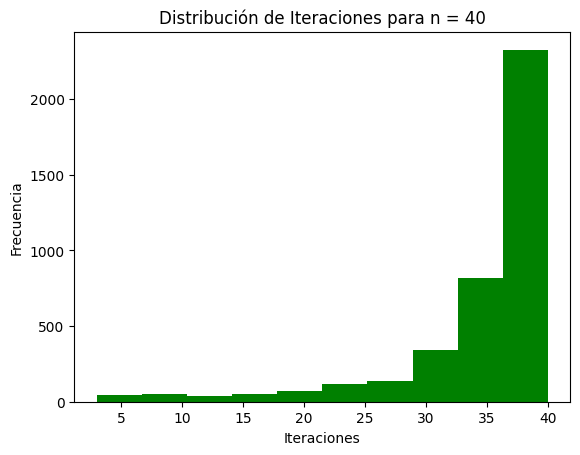

In [ ]:
print("Para n = 40")
listIter, totalIter, minIter, maxIter, aveIter = centimes(40, 100)

print(f"Total iterations: {totalIter}")
print(f"Minimum iterations: {minIter}")
print(f"Maximum iterations: {maxIter}")
print(f"Average iterations: {aveIter}")

plt.hist(listIter, color='Green')
plt.title('Distribución de Iteraciones para n = 40')
plt.ylabel('Frecuencia')
plt.xlabel('Iteraciones')
plt.show()

Simulate the the Gale-Shapley and Irving algorithms using random preference lists , for n=4 and 40 and generate a gift animation fo the type show in “Illustrating the Deferred Acceptance Algorithm with R – Code r-bloggers

In [ ]:
from PIL import Image, ImageDraw
import random